In [ ]:
!pip install mplcyberpunk
!pip install python-bcb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, but you have requests 2.31.0 which is incompatible.


In [ ]:
import mplcyberpunk
import seaborn as sns
import pandas as pd
from bcb import sgs
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from matplotlib.dates import date2num
from datetime import datetime
from datetime import timedelta
plt.style.use("cyberpunk")

In [ ]:
import numpy as np
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

<ipython-input-3-533cb06baa56>:4: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df_fgts = pd.read_csv('/content/drive/MyDrive/Dados/convenio_FGTS.csv', sep=';')
df_fgts['Data'] = pd.to_datetime(df_fgts['Data'], format='%d/%m/%Y')

In [ ]:
df_fgts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Data       23 non-null     datetime64[ns]
 1   ValorBase  23 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 496.0+ bytes


In [ ]:
# Remover vírgula e converter coluna para float
df_fgts['ValorBase'] = df_fgts['ValorBase'].str.replace(',', '.').astype(float)

In [ ]:
df_fgts.head(4)

,Data,ValorBase
0,2021-08-01,401985.0
1,2021-09-01,6335420.0
2,2021-10-01,9746163.0
3,2021-11-01,7592683.0


In [ ]:
df_fgts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Data       23 non-null     datetime64[ns]
 1   ValorBase  23 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 496.0 bytes


# MODELO ARIMA FGTS TREINO/TESTE

In [ ]:
train_size = int(len(df_fgts.ValorBase) * 2 / 3)

In [ ]:
train_set = df_fgts.ValorBase[:train_size]
test_set = df_fgts.ValorBase[train_size:]

In [ ]:
train_set.shape, test_set.shape

((15,), (8,))

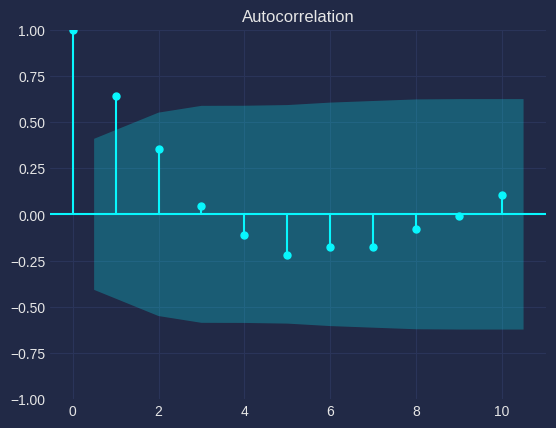

In [ ]:
plot_acf(df_fgts.ValorBase, lags=10)
pyplot.show()

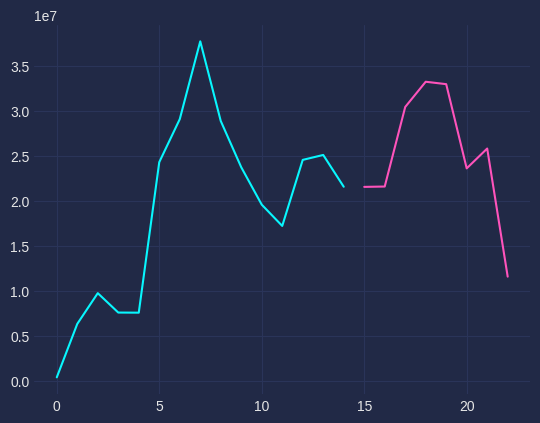

In [ ]:
plt.plot(train_set)
plt.plot(test_set)

In [ ]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import AutoReg

ar_2 = AutoReg(train_set, lags=1).fit()
ar_2.params

const           7.338556e+06
ValorBase.L1    6.882200e-01
dtype: float64

In [ ]:
previsoes = ar_2.params[0] + test_set.shift(2) * ar_2.params[1] + test_set.shift(2) * ar_2.params[1]

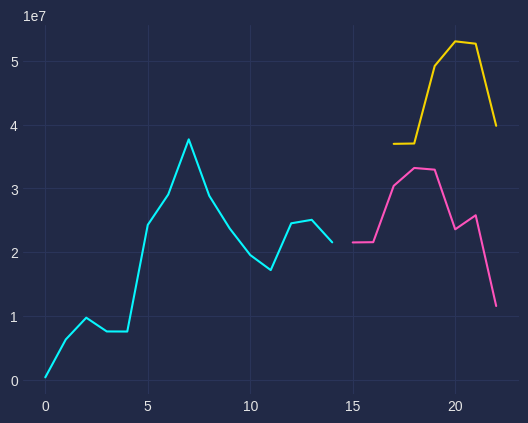

In [ ]:
plt.plot(train_set)
plt.plot(test_set)
plt.plot(previsoes)

In [ ]:
previsoes = ar_2.params[0]
for i, param in enumerate(ar_2.params[1:]):
    previsoes += test_set.shift(i + 1) * param
previsoes

15             NaN
16    2.216374e+07
17    2.219072e+07
18    2.826800e+07
19    3.019547e+07
20    3.001115e+07
21    2.357851e+07
22    2.509419e+07
Name: ValorBase, dtype: float64

In [ ]:
((test_set - previsoes)).mean()

-339924.94311666914

# PREVISÕES SARIMAX CONVENIO FGTS

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Converter coluna de datas para o tipo datetime
df_fgts['Data'] = pd.to_datetime(df_fgts['Data'])

# Definir a coluna 'Data' como o índice do DataFrame
df_fgts.set_index('Data', inplace=True)

In [ ]:
sarima = SARIMAX(df_fgts.ValorBase, freq='MS', order=(1, 0, 1), seasonal_order=(3, 1, 1, 12)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
print((sarima.resid).mean())

3209357.3684259444


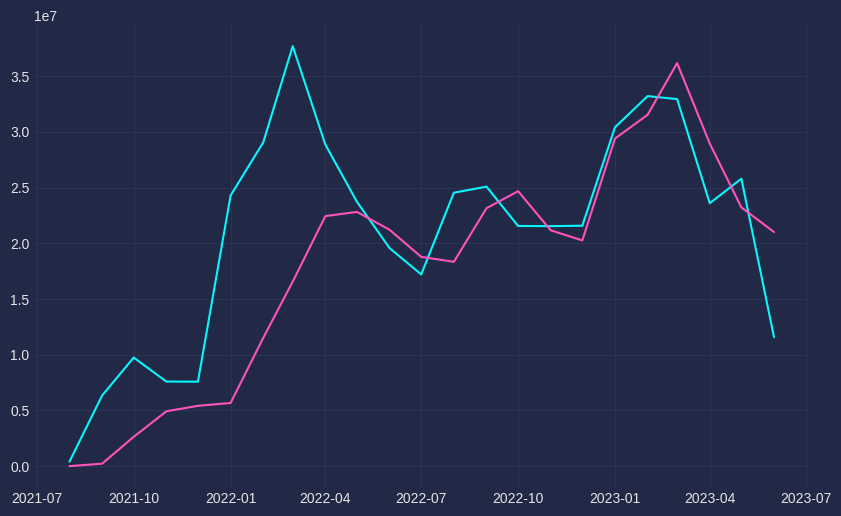

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_fgts.ValorBase)
plt.plot(sarima.predict(typ='levels'))

In [ ]:
sarima.forecast().round()

2023-07-01    15554815.0
Freq: MS, dtype: float64

In [ ]:
df_fgts.tail()

,ValorBase
Data,
2023-02-01,33211641.02
2023-03-01,32943816.75
2023-04-01,23597037.52
2023-05-01,25799363.44
2023-06-01,11578918.64


# PREVISÕES COM ARIMA CONVENIO FGTS

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
arima = ARIMA(df_fgts['ValorBase'], order=(2, 1, 3))
arima_fit = arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

In [ ]:
# Calcular o quadrado dos resíduos médios
mse = (arima_fit.resid).mean()
print(mse)

1332020.1811766746


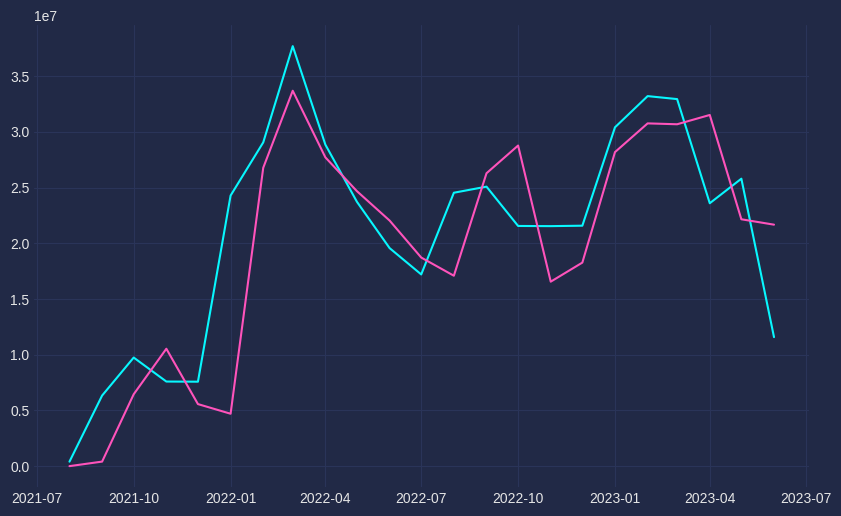

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_fgts.ValorBase)
plt.plot(arima_fit.predict(typ='levels'))

In [ ]:
# Resultado
previsão = (arima_fit.forecast(steps=6).round())
arima_fit.forecast(steps=6).round()

2023-07-01    16682142.0
2023-08-01    13047903.0
2023-09-01    18144842.0
2023-10-01    20346640.0
2023-11-01    20067184.0
2023-12-01    19576827.0
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
df_fgts.tail()

,ValorBase
Data,
2023-02-01,33211641.02
2023-03-01,32943816.75
2023-04-01,23597037.52
2023-05-01,25799363.44
2023-06-01,11578918.64


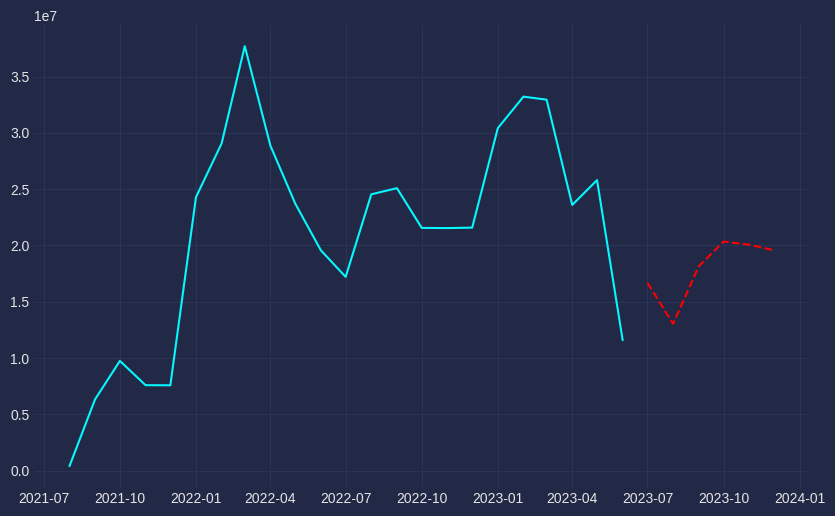

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_fgts['ValorBase'])
plt.plot(previsão, color='red', linestyle='--', label='Previsão')